In [1]:
import pandas as pd
import datetime
from fbprophet import Prophet
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from fbprophet.plot import plot_cross_validation_metric

# After importing the modules, we are defining our functions:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Number of days for the prediction

In the next line we are going to choose the number of days we want to predict. For this project we have chosen 7 days, but it can be changed for investigating:

In [2]:
days = 28

## Facebook prophet

We read the data:

In [3]:
df = pd.read_csv('./final_dataframe.csv',index_col='datetime')

We must give the format needed to the dataframe. We need to have a column named `"ds"` with the dates, and a column named `"y"` with the value

In [4]:
# Select the columns we need
new_df = df.reset_index()[['datetime','Termino_de_facturacion_de_energia_activa_del_PVPC_eficiencia_2_periodos_(DHA)']]
# Rename them
new_df.columns= ['ds','y']
# Give the date column the right format
new_df.ds = pd.to_datetime(new_df.ds)
new_df.ds = new_df.ds.dt.strftime("%Y-%m-%d %H:%M:%S")

In [5]:
# Let's select for train and test based on the number of days we selected before:
last_value = new_df.shape[0]-days*24
train = new_df.iloc[:last_value,]
test = new_df.iloc[last_value:,]

In [6]:
test['ds']

55726    2020-08-08 22:00:00
55727    2020-08-08 23:00:00
55728    2020-08-09 00:00:00
55729    2020-08-09 01:00:00
55730    2020-08-09 02:00:00
                ...         
56393    2020-09-05 17:00:00
56394    2020-09-05 18:00:00
56395    2020-09-05 19:00:00
56396    2020-09-05 20:00:00
56397    2020-09-05 21:00:00
Name: ds, Length: 672, dtype: object

We can now fit the model:

In [7]:
m = Prophet()
m.fit(train)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Let's check our model. We are going to see what  th metrics are for a cross valdiation on the fitted data. 

In [8]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(m, initial='730 days', period='180 days', horizon = str(days)+' days')

INFO:fbprophet:Making 9 forecasts with cutoffs between 2016-08-01 21:00:00 and 2020-07-11 21:00:00


In [9]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)

In [10]:
df_p

horizon         mse       rmse        mae      mape     mdape  \
0    2 days 20:00:00  113.617105  10.659132   8.134319  0.101326  0.066051   
1    2 days 21:00:00  115.672403  10.755111   8.225691  0.100905  0.067110   
2    2 days 22:00:00  115.461621  10.745307   8.224049  0.099955  0.065027   
3    2 days 23:00:00  120.163453  10.961909   8.417957  0.100486  0.067116   
4    3 days 00:00:00  125.249537  11.191494   8.624927  0.103369  0.069652   
..               ...         ...        ...        ...       ...       ...   
600 27 days 20:00:00  258.843777  16.088623  12.670233  0.162677  0.120878   
601 27 days 21:00:00  258.180313  16.067990  12.667263  0.160857  0.120878   
602 27 days 22:00:00  256.886217  16.027670  12.635547  0.158909  0.119613   
603 27 days 23:00:00  262.570655  16.204032  12.776340  0.158285  0.119613   
604 28 days 00:00:00  265.734742  16.301372  12.877030  0.159470  0.119527   

     coverage  
0    0.846026  
1    0.844003  
2    0.844371  
3    0.836093  
4    0.822848  
..        ...  
600  0.686718  
601  0.686350  
602  0.686718  
603  0.680096  
604  0.673473  

[605 rows x 7 columns]

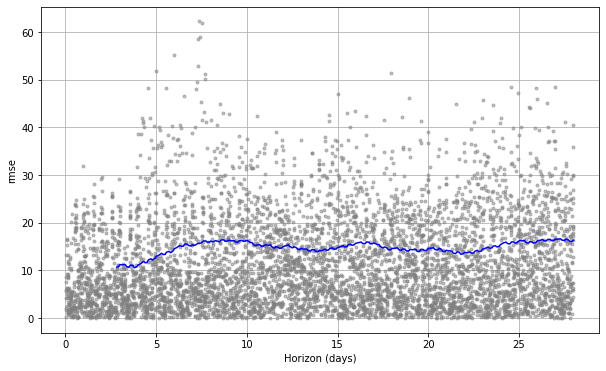

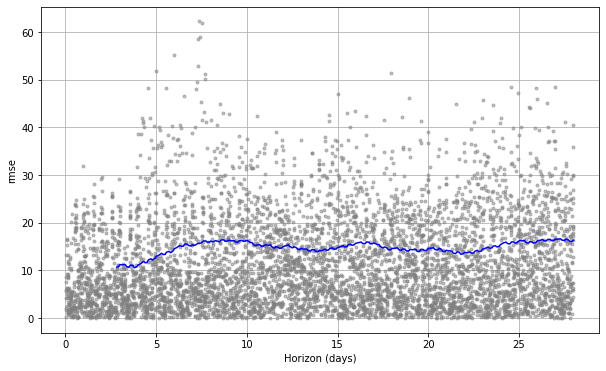

In [11]:
plot_cross_validation_metric(df_cv, metric = 'rmse')

Once we have the metrics for our model, let's predict and check it:

In [12]:
forecast = m.predict(test[['ds']])
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds        yhat  yhat_lower  yhat_upper
667 2020-09-05 17:00:00  103.333345   85.946468  119.638681
668 2020-09-05 18:00:00  112.703187   95.992438  129.151748
669 2020-09-05 19:00:00  105.741447   88.631816  122.199326
670 2020-09-05 20:00:00   80.845838   63.853437   97.598458
671 2020-09-05 21:00:00   49.687048   32.449143   66.439439

Once we have the predictions, we are having a look at the forecasting:

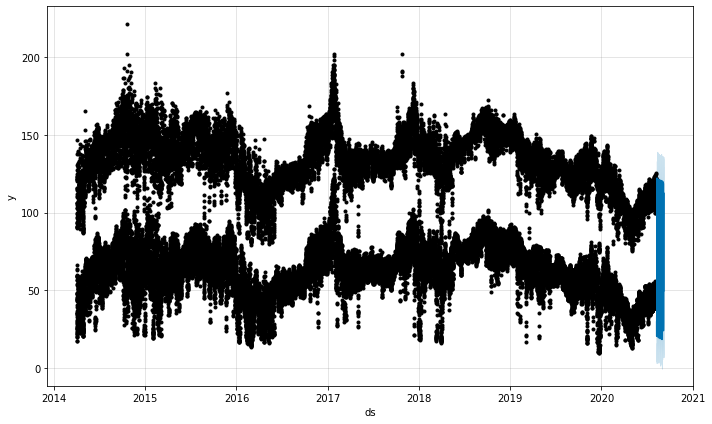

In [13]:
fig1 = m.plot(forecast)

Within the next line, we are seeing the main components from the model:

In [14]:
from fbprophet.plot import plot_plotly, plot_components_plotly
plot_components_plotly(m, forecast)

There is an interactive option for this library. With the function, using plotly, you can see an interactive plot of the data, where you can select the dates you want to check and it zooms them. The problem is that it gets slow when you use this function, so it will only be used if wanted. For safety, we are keeping it as a markdown cell with the code.

```python
from fbprophet.plot import plot_plotly, plot_components_plotly
import plotly.offline as py
py.init_notebook_mode()

fig = plot_plotly(m, forecast[yhat])  # This returns a plotly Figure
py.iplot(fig)
```


Finally, let's check the results

In [15]:
forecast

ds      trend  yhat_lower  yhat_upper  trend_lower  \
0   2020-08-08 22:00:00  62.989621   12.523341   45.484796    62.989621   
1   2020-08-08 23:00:00  62.986875    3.353956   38.800953    62.986875   
2   2020-08-09 00:00:00  62.984130    7.777581   41.635224    62.984130   
3   2020-08-09 01:00:00  62.981384    8.852654   40.935378    62.981384   
4   2020-08-09 02:00:00  62.978639    6.757894   39.753136    62.978639   
..                  ...        ...         ...         ...          ...   
667 2020-09-05 17:00:00  61.158370   85.946468  119.638681    60.903722   
668 2020-09-05 18:00:00  61.155624   95.992438  129.151748    60.899551   
669 2020-09-05 19:00:00  61.152879   88.631816  122.199326    60.895379   
670 2020-09-05 20:00:00  61.150133   63.853437   97.598458    60.891208   
671 2020-09-05 21:00:00  61.147388   32.449143   66.439439    60.887036   

     trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0      62.989621      -33.322694            -33.322694            -33.322694   
1      62.986875      -41.030762            -41.030762            -41.030762   
2      62.984130      -39.288901            -39.288901            -39.288901   
3      62.981384      -37.568490            -37.568490            -37.568490   
4      62.978639      -39.842022            -39.842022            -39.842022   
..           ...             ...                   ...                   ...   
667    61.363360       42.174975             42.174975             42.174975   
668    61.361314       51.547563             51.547563             51.547563   
669    61.361228       44.588568             44.588568             44.588568   
670    61.360139       19.695705             19.695705             19.695705   
671    61.358183      -11.460339            -11.460339            -11.460339   

         daily  ...    weekly  weekly_lower  weekly_upper    yearly  \
0   -28.728365  ... -5.675767     -5.675767     -5.675767  1.081438   
1   -36.250453  ... -5.857059     -5.857059     -5.857059  1.076751   
2   -34.346491  ... -6.014496     -6.014496     -6.014496  1.072086   
3   -32.489306  ... -6.146625     -6.146625     -6.146625  1.067441   
4   -34.652656  ... -6.252184     -6.252184     -6.252184  1.062818   
..         ...  ...       ...           ...           ...       ...   
667  46.248641  ... -4.473202     -4.473202     -4.473202  0.399536   
668  55.893781  ... -4.746668     -4.746668     -4.746668  0.400450   
669  49.192919  ... -5.005726     -5.005726     -5.005726  0.401375   
670  24.541655  ... -5.248258     -5.248258     -5.248258  0.402308   
671  -6.391349  ... -5.472242     -5.472242     -5.472242  0.403252   

     yearly_lower  yearly_upper  multiplicative_terms  \
0        1.081438      1.081438                   0.0   
1        1.076751      1.076751                   0.0   
2        1.072086      1.072086                   0.0   
3        1.067441      1.067441                   0.0   
4        1.062818      1.062818                   0.0   
..            ...           ...                   ...   
667      0.399536      0.399536                   0.0   
668      0.400450      0.400450                   0.0   
669      0.401375      0.401375                   0.0   
670      0.402308      0.402308                   0.0   
671      0.403252      0.403252                   0.0   

     multiplicative_terms_lower  multiplicative_terms_upper        yhat  
0                           0.0                         0.0   29.666927  
1                           0.0                         0.0   21.956114  
2                           0.0                         0.0   23.695229  
3                           0.0                         0.0   25.412894  
4                           0.0                         0.0   23.136617  
..                          ...                         ...         ...  
667                         0.0                         0.0  103.333345  
668                         0

Checking the forecasting for the last days:

Para los resultados de las últimas 4 semanas se obtiene un RMSE de  17.550550631625185 , un R2 de  0.7384108697787883  y un MAPE de 23.431270959223202


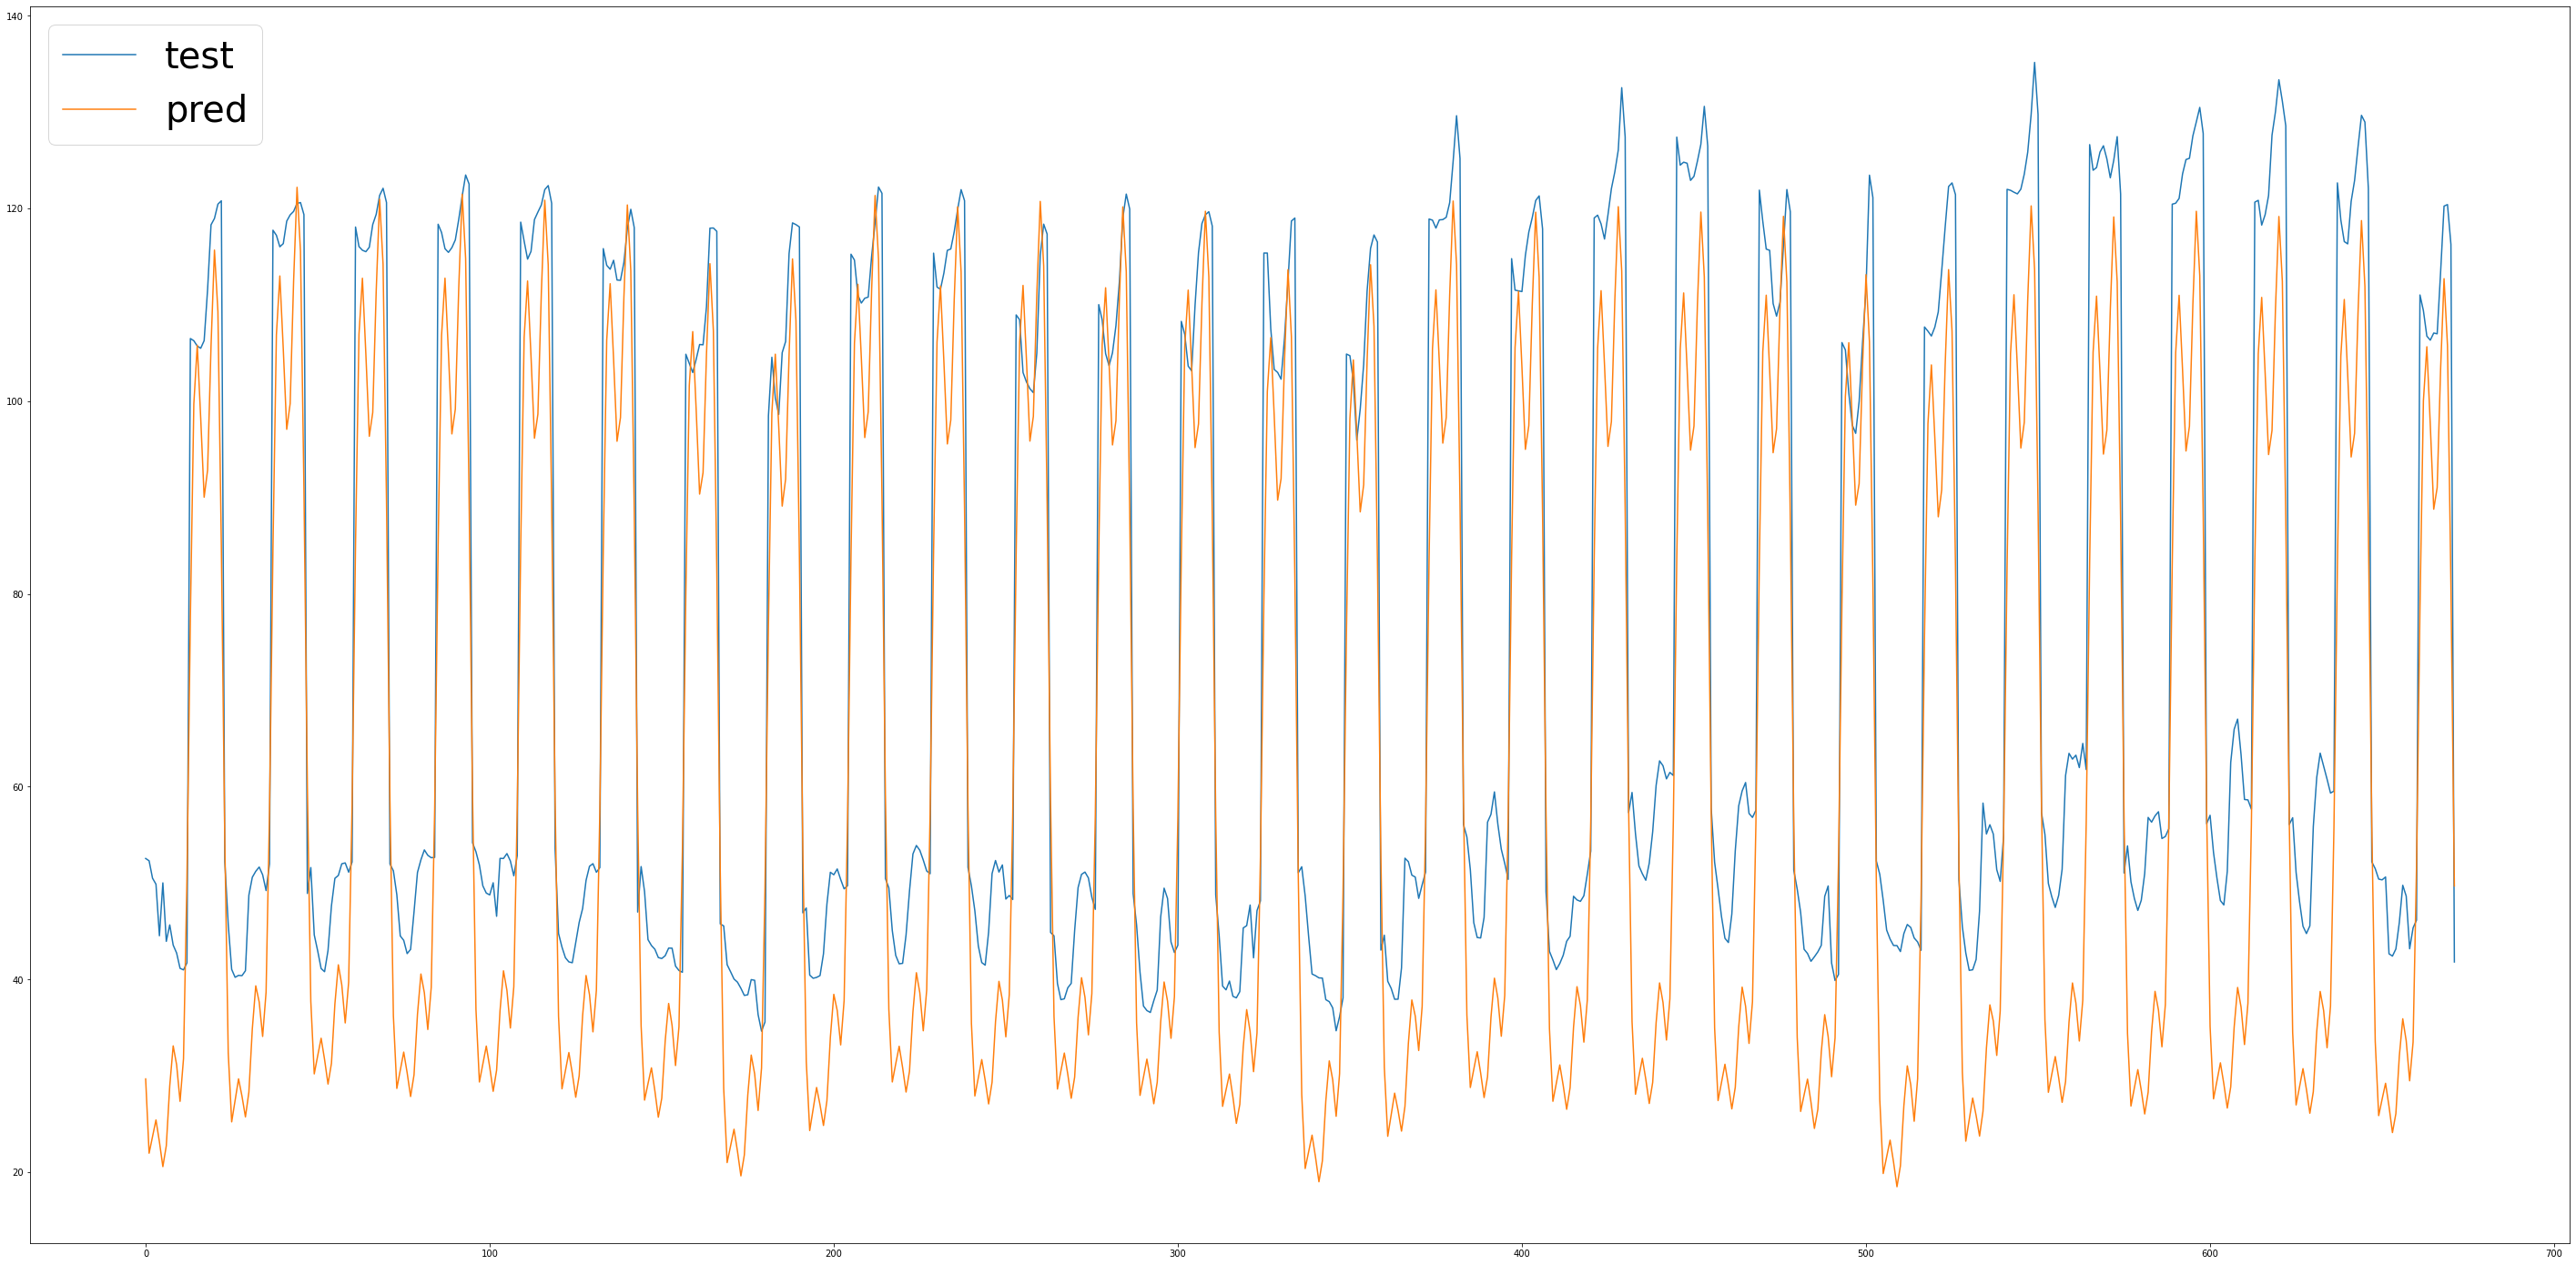

In [16]:
# Let's plot the results and check the metrics.
y_test_days = test['y'].copy()
y_pred_days = forecast['yhat'].copy()
print('Para los resultados de las últimas 4 semanas se obtiene un RMSE de ',np.sqrt(mean_squared_error(y_test_days, y_pred_days)),', un R2 de ',r2_score(y_test_days, y_pred_days),' y un MAPE de',mean_absolute_percentage_error(y_test_days, y_pred_days))
plt.rcParams['figure.figsize'] = [50, 25]
plt.plot(test['y'].reset_index().drop('index',axis=1), label='test')
plt.plot(forecast['yhat'], label='pred')
plt.legend(prop={'size': 40})
plt.show()

Finally, we export the results for the visualization

In [17]:
pd.DataFrame({'test':test['y'].values, 'prediccion':forecast['yhat'].values},index = test['ds'].values).to_csv('./../Visualization/Facebook_prophet.csv')

## SARIMAX

First, we read the data:

In [18]:
df = pd.read_csv('./final_dataframe.csv',index_col='datetime')

We can recycle the code from the FP model so we give our data the format needed:

In [19]:
# Select the columns we need
new_df = df.reset_index()[['datetime','Termino_de_facturacion_de_energia_activa_del_PVPC_eficiencia_2_periodos_(DHA)']]
# Rename them
new_df.columns= ['ds','y']
# Give the date column the right format
new_df.ds = pd.to_datetime(new_df.ds)
new_df.ds = new_df.ds.dt.strftime("%Y-%m-%d %H:%M:%S")
# Finally we set again ds as index:
new_df = new_df.set_index('ds')

In [20]:
# Let's select for train and test based on the number of days we selected before:
last_value = new_df.shape[0]-days*24
train = new_df.iloc[:last_value,]
test = new_df.iloc[last_value:,]

Before we fit the model, as we said in the document from the project, we are using **auto_arima** so we can find the best model for our data. As it takes quite a lot of time to find the best model, we are just plotting the code used and the results obtained. It is important to say that, to avoid crashing, we reduced the size of the train data from April 2014 to January 2016.

>```python
train = train.loc['2016-01-01 00:00:00':]
start = new_df.index.get_loc('2016-01-01 00:00:00')
```

>```python
import pmdarima as pm
model = pm.auto_arima(
    train,
    stationary = False,
    m=12,
    n_jobs = -1,
    exogenous = df.iloc[start:last_value,list(df.columns).index('holidays')].values.reshape(df.shape[0]-start-last_value,1),
    suppress_warnings=True
)
```

>```python
model.summary()
```

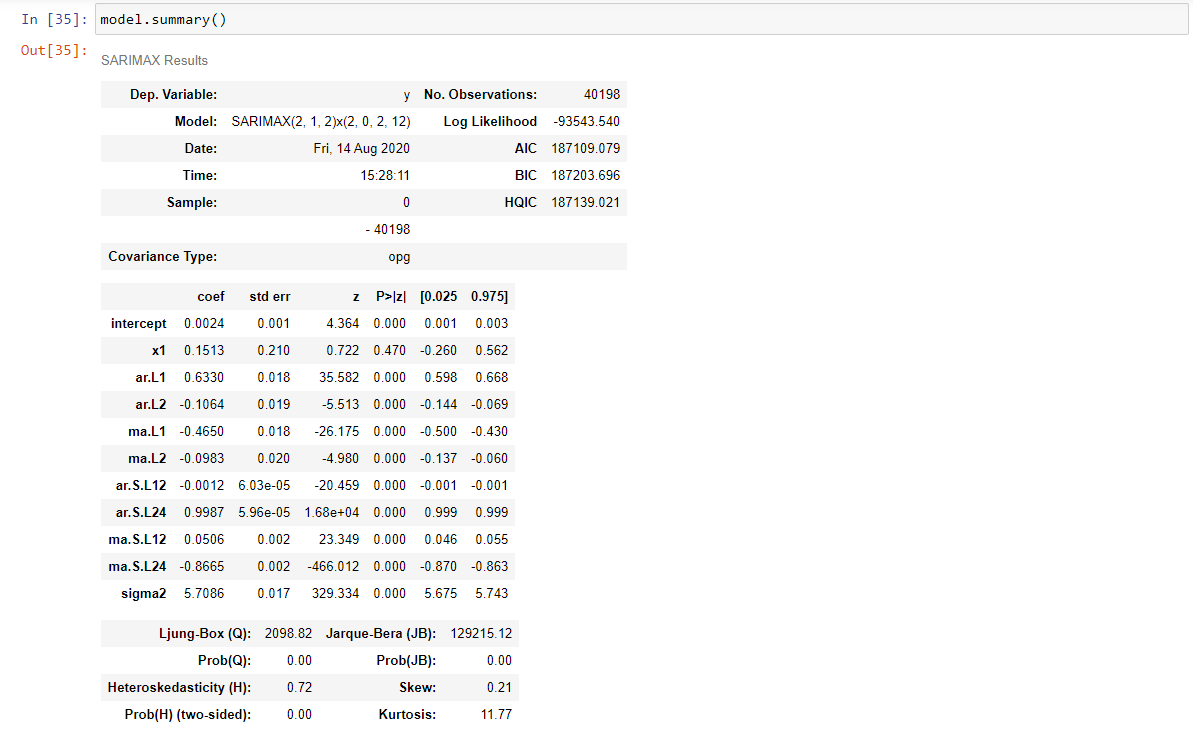

So, we fit the model with those hyperparameters:

In [21]:
model2 = SARIMAX(train, 
                 order = (2, 1, 2), 
                 seasonal_order = (2, 0, 2, 12),
                 exog = df.iloc[:last_value,list(df.columns).index('holidays')].values.reshape(df.shape[0]-24*days,1)
                ).fit()

/home/joeldela/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency H will be used.

/home/joeldela/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency H will be used.



In [22]:
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                55726
Model:             SARIMAX(2, 1, 2)x(2, 0, 2, 12)   Log Likelihood             -133746.304
Date:                            Sat, 05 Sep 2020   AIC                         267512.607
Time:                                    14:21:41   BIC                         267601.889
Sample:                                04-01-2014   HQIC                        267540.434
                                     - 08-08-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0772      0.017      4.607      0.000       0.044       0.110
ar.L1          0.8985      0.018     51.279      0.000       0.864       0.933
ar.L2          0.0297      0.017      1.781      0.075      -0.003       0.062
ma.L1         -0.7896      0.017    -45.912      0.000      -0.823      -0.756
ma.L2         -0.2090      0.017    -12.160      0.000      -0.243      -0.175
ar.S.L12      -0.0007   4.01e-05    -17.979      0.000      -0.001      -0.001
ar.S.L24       0.9992   4.12e-05   2.42e+04      0.000       0.999       0.999
ma.S.L12       0.0225      0.002     11.206      0.000       0.019       0.026
ma.S.L24      -0.8529      0.002   -533.225      0.000      -0.856      -0.850
sigma2         7.0932      0.021    344.984      0.000       7.053       7.134
===================================================================================
Ljung-Box (Q):                     1941.02   Jarque-Bera (JB):            106654.94
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.48   Skew:                             0.07
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

We can plot the train and the fitted values so we know how our model performs in the train data:

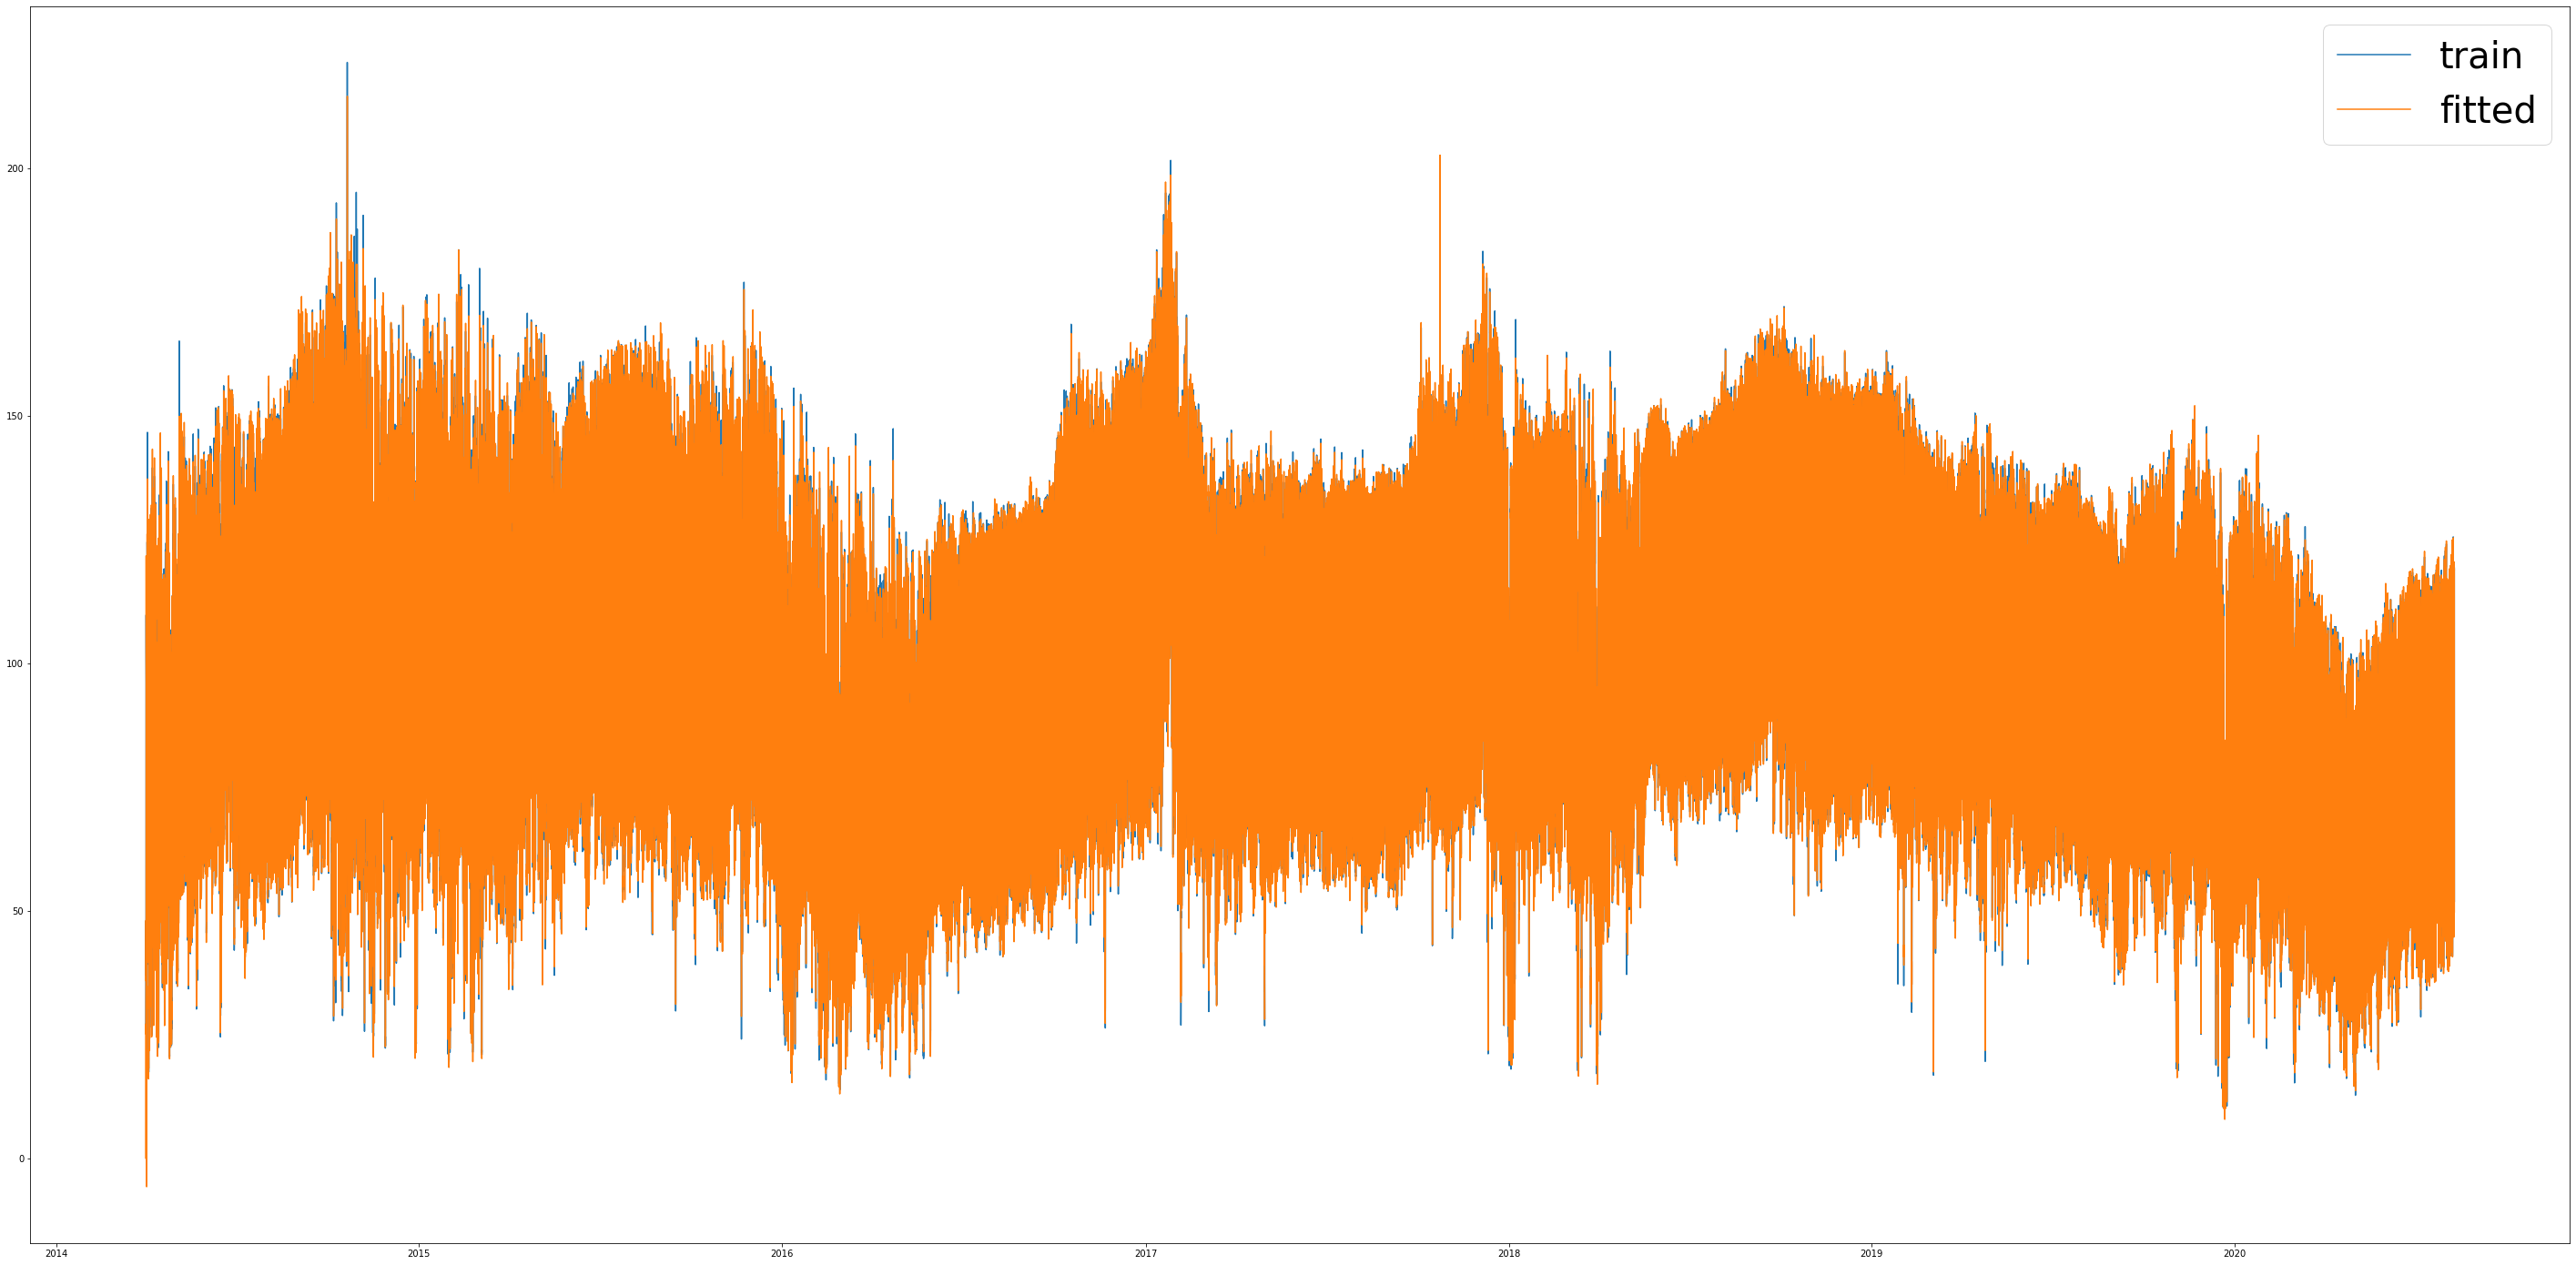

In [23]:
#Let's parse dates:
train.index = pd.to_datetime(train.index)
fitted_values = pd.Series(model2.fittedvalues)
fitted_values.index = pd.to_datetime(fitted_values.index)
# Let's plot both series:
plt.plot(train['y'], label='train')
plt.plot(fitted_values, label='fitted')
plt.legend(prop={'size': 40})

Let's predict the values for the number of hours and days selected before:

In [24]:
forecast_mean2 = model2.forecast(24*days, 
                                 exog = df.iloc[last_value:,list(df.columns).index('holidays')].values.reshape(24*days,1), 
                                 return_conf_int = True)
forecast_mean2

2020-08-08 22:00:00     51.352532
2020-08-08 23:00:00     47.709967
2020-08-09 00:00:00     45.839183
2020-08-09 01:00:00     45.632393
2020-08-09 02:00:00     45.727854
                          ...    
2020-09-05 17:00:00    121.595672
2020-09-05 18:00:00    123.181902
2020-09-05 19:00:00    122.750406
2020-09-05 20:00:00    122.511086
2020-09-05 21:00:00     54.723058
Freq: H, Length: 672, dtype: float64

Let's check the predictions:

Para los resultados de las últimas 4 semanas se obtiene un RMSE de  6.15316473655467 , un R2 de  0.9678459794054348  y un MAPE de 7.686197056522472


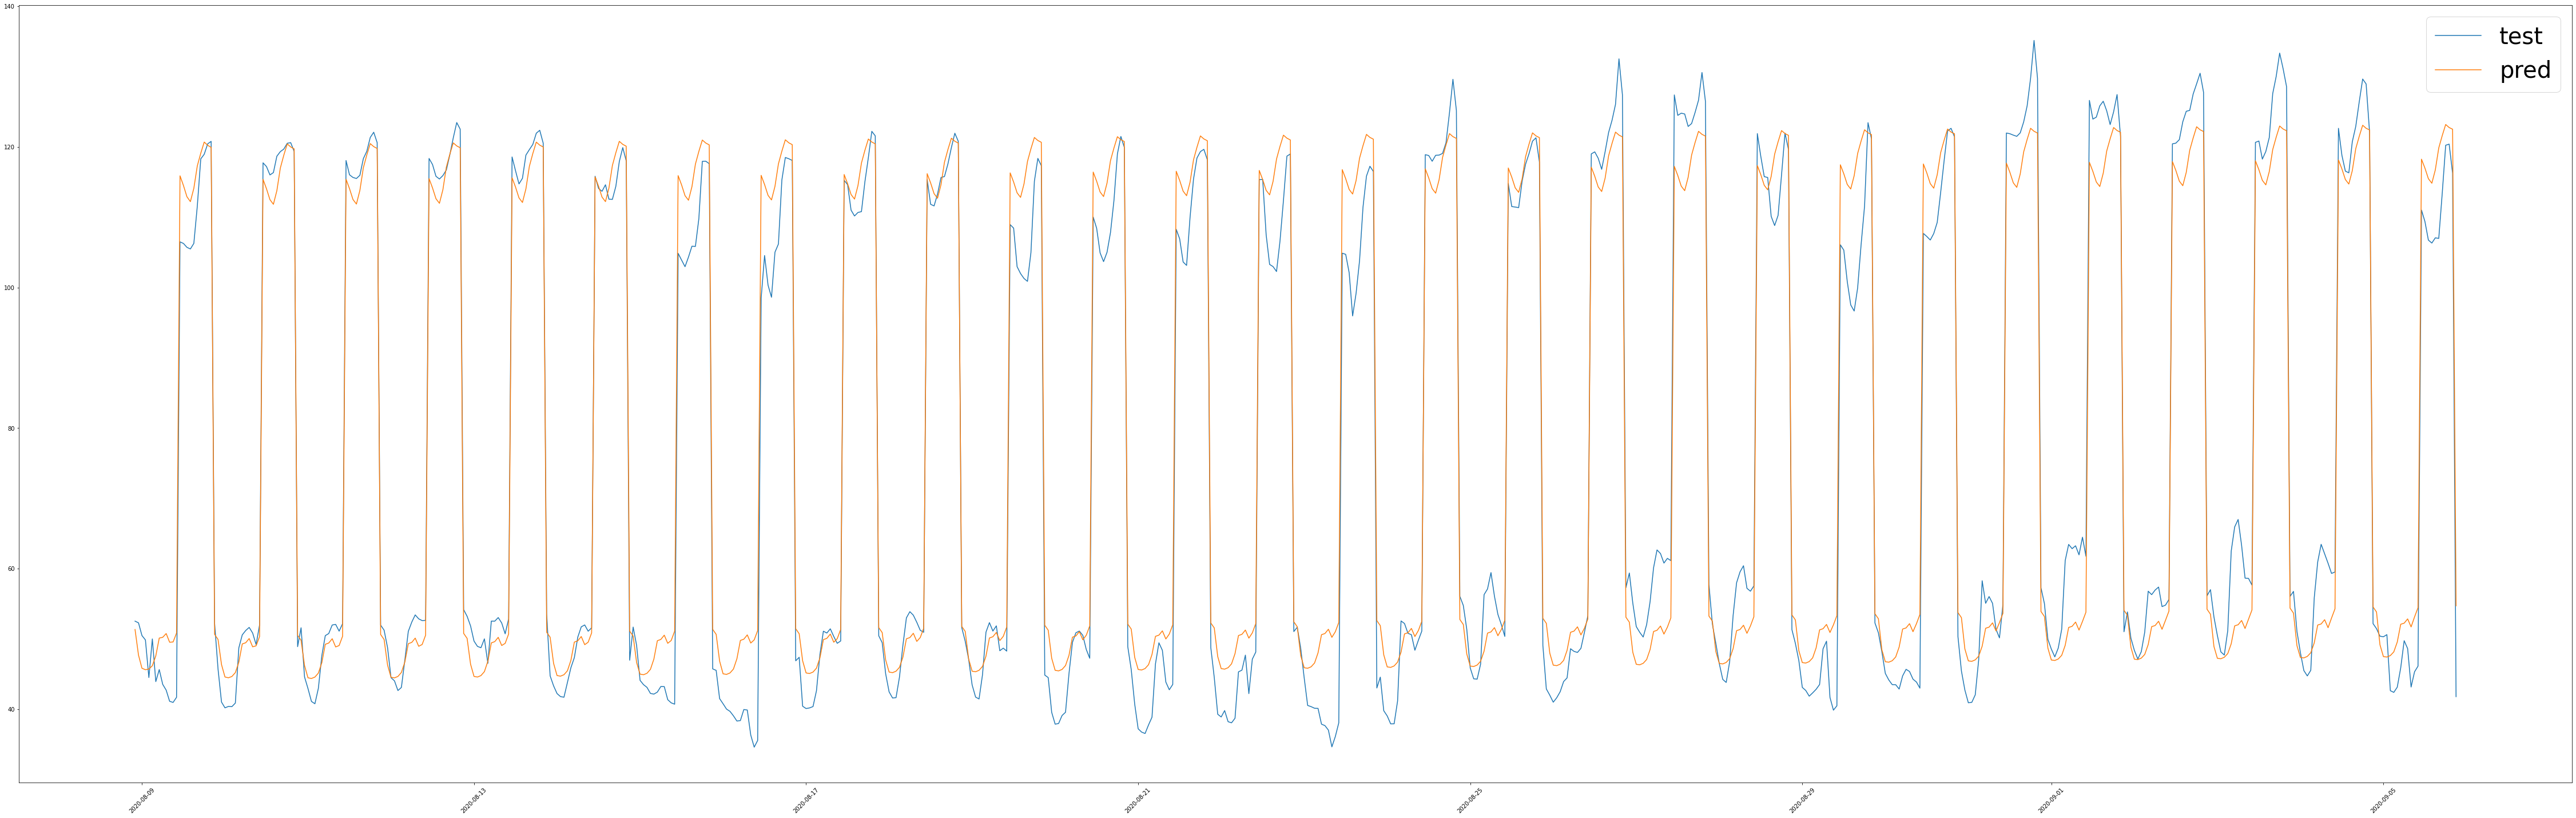

In [25]:
# Let's define the variables:
y_test = test['y']
y_pred = pd.Series(forecast_mean2, index=forecast_mean2.index)
y_test.index =  pd.to_datetime(y_test.index)
y_pred.index =  pd.to_datetime(y_pred.index)
# Now we print the metrics
print('Para los resultados de las últimas 4 semanas se obtiene un RMSE de ',np.sqrt(mean_squared_error(y_test, y_pred)),', un R2 de ',r2_score(y_test, y_pred),' y un MAPE de',mean_absolute_percentage_error(y_test, y_pred))
# Finally we plot the results:
plt.rcParams['figure.figsize'] = [80, 25]
plt.plot(y_test, label='test')
plt.plot(y_pred, label='pred')
plt.legend(prop={'size': 40})
plt.xticks(rotation=45, fontsize = 10)
plt.show()

Finally, we export the results for the visualization

In [26]:
pd.DataFrame({'test':y_test, 'prediccion': y_pred},index = test.index).to_csv('./../Visualization/SARIMAX.csv')